![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Image Analysis: The Attention Maps

### Imports

Let's start with importing all required Python packages.

In [1]:
%matplotlib inline
import sys
import os
import json
import ipywidgets as widgets

from PIL import Image as PILImage
import torchvision
from torchvision import transforms
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 

import shap
import warnings
warnings.filterwarnings("ignore")

import utils
sys.path.append('../data_and_models/')
from vit import VitGenerator

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Data Loading

We first load the image we want to analyse and convert the it to RGB channel, 

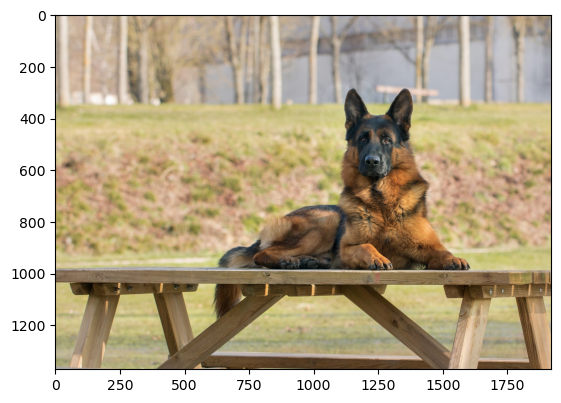

Image size:  (1371, 1920, 3)


In [3]:
# Visualizing Dog Image
# '../data_and_models/images/Iguana.jpeg'
path = '../data_and_models/images/dog.jpg'
img = utils.read_img(path)
plt.imshow(img)
plt.show()

print("Image size: ", img.shape)


We need to perform some transformations to the image (convert to PIL format, resize to lower resolution, convert to tensor dtype and normalize the pixel values) and unsqueeze the image to add a batch dimension.

Because the image size is too big. We will reduce it by a factor of 2. 
Resizing the image here can be for several reasons.
- If the image is too large, attention maps might be too detailed and harder to interpret. By reducing the size, attention patterns might become more evident, providing clearer insights into which parts of the image the model focuses on.
- Reducing the image size might ensure that patches cover meaningful parts of the image and don't introduce artifacts due to partial objects or features.
- Larger images have more pixels, and processing them can be computationally expensive. Reducing the image size can make the processing faster, especially when using deep learning models.
- Large images consume more memory. If the model or subsequent processes require a significant amount of memory, reducing the image size can help in avoiding out-of-memory errors, especially on GPUs.

![logo](/p/project/training2324/benassou1/XAI-Tutorials/am)

In [4]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

factor_reduce = 2
img_size = tuple(np.array(img.shape[:2]) // factor_reduce)

img_pre = utils.transform_img(img, mean, std, img_size=img_size)
print('Transformed image size: ', img_pre.size())
     

Transformed image size:  torch.Size([1, 3, 685, 960])


## Model Loading
 
Let's load our model.

We check the available device (either cpu or gpu)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(1)

We instanciate a vision transformer (VitGenerator) that we will use for the classifcation of the image that we just loaded. 
The class VitGenerator takes the following arguments:
- name_model where we have the choice between three pretrained transformer models: vit_tiny, vit_small, and vit_base. Here, we will use vit_small that has 8 heads. 
- patch_size which is the size of each square patch. The image is divided into patches of this size.
- device which the computing device (CPU or GPU) to which tensors should be sent before performing operations.
- evaluate to specify that we want to use the model in eval mode and not training mode.
- random to specify that we do want a pretrained model.
- verbose to print some infor concerning the patch size and the loading of the data.

In [6]:
name_model = 'vit_small'
patch_size = 8

model = VitGenerator(name_model, patch_size, 
                     device, evaluate=True, random=False, verbose=True)

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


Now, let's generate our attention maps. 
1. We first ensure that the image's width and height are divisible by the patch size. We trim the image if necessary.
2. Once the image is resized, we compute the width and height of the feature map by dividing the image's dimensions by the patch size.
3. We then retrieve the attention weights from the model for the given image. The image is first sent to the specified device.
4. we reshape the attention weights for visualization. The attention tensor is assumed to have a shape of [batch_size, num_heads, num_patches, num_patches], where each entry indicates attention from one patch to another. The code extracts the attention weights of the first item in the batch (since we're visualizing for one image), and focuses on the attention from the first patch (i.e., the [CLS] token in some Transformer architectures) to all other patches. The [CLS] token serves as a mechanism to aggregate and capture global or holistic information from the input, whether that input is a sequence of words or a sequence of image patches. So we will extract its attention maps and visualize them.
5. Finally, the attention weights are upscaled to match the original image dimensions. This is done using the nearest-neighbor interpolation. The upscaled attention maps are then converted from tensors to numpy arrays for visualization.

In [7]:
w, h = img_pre.shape[2] - img_pre.shape[2] % patch_size, img_pre.shape[3] - \
    img_pre.shape[3] % patch_size
img_pre = img_pre[:, :, :w, :h]

w_featmap = img_pre.shape[-2] // patch_size
h_featmap = img_pre.shape[-1] // patch_size

# Get the attention maps
attentions = model.get_last_selfattention(img_pre.to(device))
print("Attentions shape: ", attentions.shape)
nh = attentions.shape[1]  # number of head

# keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
attentions = attentions.reshape(nh, w_featmap, h_featmap)

# resize the attention map to the size of the resized input image
attentions = nn.functional.interpolate(attentions.unsqueeze(
    0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


Attentions shape:  torch.Size([1, 6, 10201, 10201])


## Vizualization

We plot two figures, the first diplay the orginal image and the mean of the 8 heads. The second display the 6 attention weights of each head. 

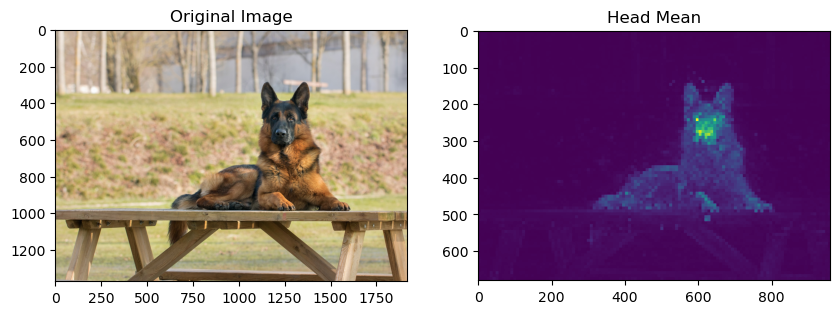

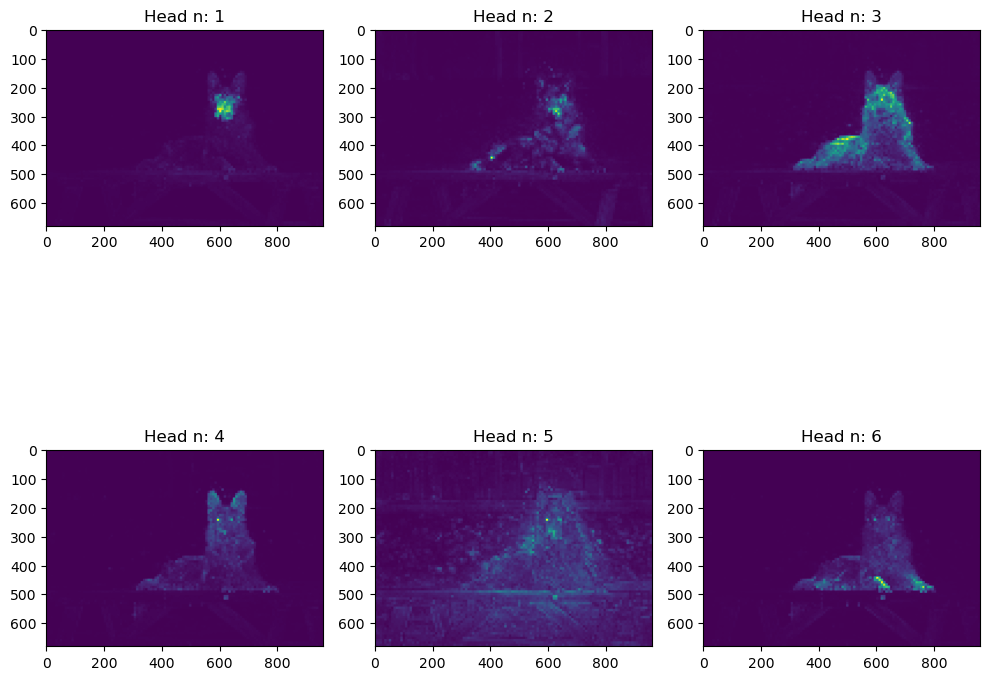

In [8]:
n_heads = attentions.shape[0]

plt.figure(figsize=(10, 10))
text = ["Original Image", "Head Mean"]
for i, fig in enumerate([img, np.mean(attentions, 0)]):
    plt.subplot(1, 2, i+1)
    plt.imshow(fig)
    plt.title(text[i])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(n_heads):
    plt.subplot(n_heads//3, 3, i+1)
    plt.imshow(attentions[i])
    plt.title(f"Head n: {i+1}")
plt.tight_layout()
plt.show()

## Another Example

Lets try to extract the attention maps of our Iguana.

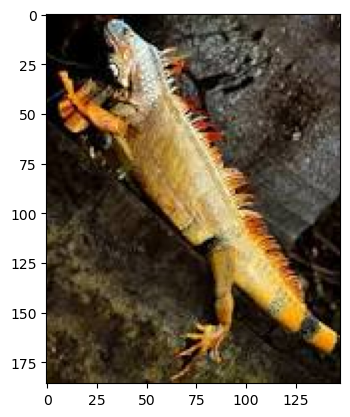

Image size:  (186, 148, 3)


In [9]:
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = utils.read_img(path_to_img)
plt.imshow(img)
plt.show()

print("Image size: ", img.shape)

Our Iguana Image is not really big. So we do not need to reduce it. We just convert it to a tensor and normalize it.

In [10]:
img_size = img.shape[:2]
img_pre = utils.transform_img(img, mean, std, img_size=img_size)
print('Transformed image size: ', img_pre.size())

Transformed image size:  torch.Size([1, 3, 186, 148])


Since the image is small we set a patch_size of 2

In [11]:
name_model = 'vit_small'
patch_size = 2

model = VitGenerator(name_model, patch_size, 
                     device, evaluate=True, random=False, verbose=True)


[INFO] Initializing vit_small with patch size of 2
[INFO] Loading weights
Since no pretrained weights have been found with name vit_small and patch size 2, random weights will be used


Here we upscale the attentiion map to the original image by specifying the original image size.

In [12]:
# make the image divisible by the patch size
w, h = img_pre.shape[2] - img_pre.shape[2] % patch_size, img_pre.shape[3] - \
    img_pre.shape[3] % patch_size

img_pre = img_pre[:, :, :w, :h]
w_featmap = img_pre.shape[-2] // patch_size
h_featmap = img_pre.shape[-1] // patch_size

attentions = model.get_last_selfattention(img_pre.to(device))

nh = attentions.shape[1]  # number of head

# keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(
    0), size=img_size, mode="nearest")[0].cpu().numpy()


Plot the attention maps

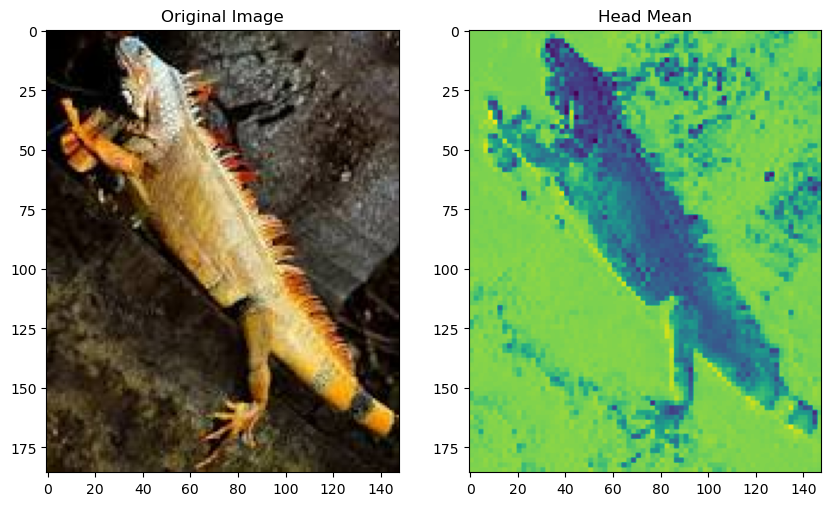

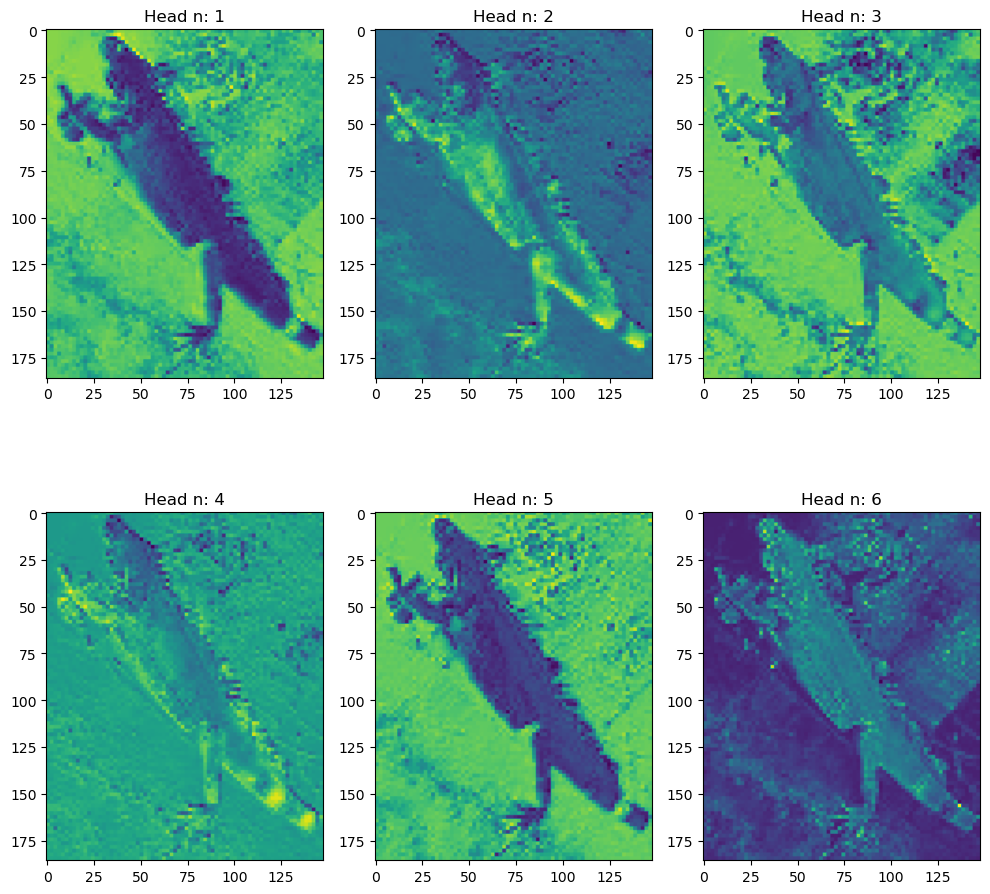

In [13]:
n_heads = attentions.shape[0]

plt.figure(figsize=(10, 10))
text = ["Original Image", "Head Mean"]
for i, fig in enumerate([img, np.mean(attentions, 0)]):
    plt.subplot(1, 2, i+1)
    plt.imshow(fig)
    plt.title(text[i])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(n_heads):
    plt.subplot(n_heads//3, 3, i+1)
    plt.imshow(attentions[i])
    plt.title(f"Head n: {i+1}")
plt.tight_layout()
plt.show()